In [21]:
import pandas as pd
import numpy as np
import dask.array as da
import dask.dataframe as dd
import dask.delayed as delayed
import time
import math
#import graphviz
from netCDF4 import Dataset
import os,datetime,sys,fnmatch
import h5py
import dask

In [2]:
def read_filelist(loc_dir,prefix,unie,fileformat):
    # Read the filelist in the specific directory
    str = os.popen("ls "+ loc_dir + prefix + unie + "*."+fileformat).read()
    fname = np.array(str.split("\n"))
    fname = np.delete(fname,len(fname)-1)
    
    return fname

def read_MODIS(fname1,fname2,verbose=False): # READ THE HDF FILE
    # Read the cloud mask from MYD06_L2 product')
    ncfile=Dataset(fname1,'r')
    CM1km = np.array(ncfile.variables['Cloud_Mask_1km'])
    CM   = (np.array(CM1km[:,:,0],dtype='byte') & 0b00000110) >>1
    #ncfile = Dataset(fname1, "r")
    #CM = myd06.variables["Cloud_Mask_1km"][:,:,:] # Reading Specific Variable 'Cloud_Mask_1km'.
    #CM   = (np.array(CM[:,:,0],dtype='byte') & 0b00000110) >>1
    ncfile.close()
    
    ncfile=Dataset(fname2,'r')
    lat  = np.array(ncfile.variables['Latitude'])
    lon  = np.array(ncfile.variables['Longitude'])
    #ncfile = Dataset(MOD03_files, "r")
    #latitude = myd03.variables["Latitude"][:,:] # Reading Specific Variable 'Latitude'.
    #latitude = np.array(latitude).byteswap().newbyteorder() # Addressing Byteswap For Big Endian Error.
    #longitude = myd03.variables["Longitude"][:,:] # Reading Specific Variable 'Longitude'.
    attr_lat = ncfile.variables['Latitude']._FillValue
    attr_lon = ncfile.variables['Longitude']._FillValue
    """#Use _FillValue to remove fill data in lat & lon
    lat[np.where(lat == attr_lat)] = 0.0
    lon[np.where(lat == attr_lat)] = 0.0
    CM [np.where(lat == attr_lat)] = 0.5 #which will not be identified by lines 80-83 
    lat[np.where(lon == attr_lon)] = 0.0
    lon[np.where(lon == attr_lon)] = 0.0
    CM [np.where(lon == attr_lon)] = 0.5 #which will not be identified by lines 80-83
    ncfile.close()"""
    return lat,lon,CM

In [3]:
def value_locate(refx, x):
    refx = np.array(refx)
    x = np.array(x)
    loc = np.zeros(len(x), dtype='int')
    
    for i in np.arange(len(x)):
        ix = x[i]
        ind = ((refx - ix) <= 0).nonzero()[0]
        if len(ind) == 0:
            loc[i] = -1
        else: loc[i] = ind[-1]

    return loc

def division(n, d):

    div = np.zeros(len(d))
    for i in range(len(d)):
        if d[i] >0:
          div[i]=n[i]/d[i]
        else: div[i]=None 

    return div

def countzero(x, axis=1):
    #print(x)
    count0 = 0
    count1 = 0
    for i in x:
        if i <= 1:
            count0 +=1
    #print(count0/len(x))
    return (count0/len(x))

satellite = 'Aqua'

yr = [2008]
mn = [1] #np.arange(1,13)  #[1]
dy = [1] #np.arange(1,32) # [1] #np.arange(1,31)
lat_bnd = np.arange(-90,91,1)# latitude and longtitude boundaries of level-3 grid
lon_bnd = np.arange(-180,180,1)
nlat = 180
nlon = 360

TOT_pix      = np.zeros(nlat*nlon)
CLD_pix      = np.zeros(nlat*nlon)

In [4]:
MYD06_dir= '/Users/dprakas1/Desktop/modis_files/'
MYD06_prefix = 'MYD06_L2.A2008'
MYD03_dir= '/Users/dprakas1/Desktop/modis_files/'
MYD03_prefix = 'MYD03.A2008'
fileformat = 'hdf'

fname1,fname2 = [],[]


days = np.arange(1,31,dtype=np.int)
for day in days:
    dc ='%03i' % day
    fname_tmp1 = read_filelist(MYD06_dir,MYD06_prefix,dc,fileformat)
    fname_tmp2 = read_filelist(MYD03_dir,MYD03_prefix,dc,fileformat)
    fname1 = np.append(fname1,fname_tmp1)
    fname2 = np.append(fname2,fname_tmp2)

# Initiate the number of day and total cloud fraction
files  = np.arange(len(fname1))



for j in range(0,1):#hdfs:
    print('steps: ',j+1,'/ ',(fname1)) 

    # Read Level-2 MODIS data
    lat,lon,CM = read_MODIS(fname1[j],fname2[j])
print((fname2))
#rint(CM)
#lat = lat.ravel()
#lon = lon.ravel()
#CM  = CM.ravel()
CM.shape

steps:  1 /  ['/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0000.006.2013341193524.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0005.006.2013341193207.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0010.006.2013341192125.hdf']
['/Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0000.006.2012066122450.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0005.006.2012066122516.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0010.006.2012066122416.hdf']


(2030, 1354)

In [33]:
%%time
b1=[]
cloud_pix = np.zeros((180, 360))
for x,y in zip(fname1,fname2):
    cm = np.zeros((2030,1354), dtype=np.float32)
    lat = np.zeros((2030,1354), dtype=np.float32)
    lon = np.zeros((2030,1354), dtype=np.float32)
    print(x,y)
    myd06 = Dataset(x, "r")
    CM = myd06.variables["Cloud_Mask_1km"][:,:,0]# Reading Specific Variable 'Cloud_Mask_1km'.
    CM = (np.array(CM,dtype='byte') & 0b00000110) >>1
    CM = np.array(CM).byteswap().newbyteorder()
    
    print("CM intial shape:",CM.shape)
    cm = da.concatenate((cm,CM),axis=0)
    #print("CM shape after con:",cm.shape)
    cm=da.ravel(cm)
    print("cm shape after ravel:",cm.shape)
    myd03 = Dataset(y, "r")
    latitude = myd03.variables["Latitude"][:,:]
    longitude = myd03.variables["Longitude"][:,:]
    print("Lat intial shape:",latitude.shape)
    print("lon intial shape:",longitude.shape)
    
    lat = da.concatenate((lat,latitude),axis=0)
    lon = da.concatenate((lon,longitude),axis=0)
    print("lat shape after con:",lat.shape)
    print("lon shape after con:",lon.shape)
    
    lat=da.ravel(lat)
    lon=da.ravel(lon)
    
    print("lat shape after ravel:",lat.shape)
    print("lon shape after ravel:",lon.shape)
    cm=cm.astype(int)
    lon=lon.astype(int)
    lat=lat.astype(int)
    
    Lat=lat.to_dask_dataframe()
    Lon=lon.to_dask_dataframe()
    CM=cm.to_dask_dataframe()
    df=dd.concat([Lat,Lon,CM],axis=1,interleave_partitions=False)
    print(type(df))
    
    cols = {0:'Latitude',1:'Longitude',2:'CM'}
    df = df.rename(columns=cols)
    
    df2=(df.groupby(['Longitude','Latitude']).CM.apply(countzero).reset_index())
    print(type(df2))
    df3=df2.compute()
    
    df4=[df3['Longitude'].values,df3['Latitude'].values,df3['CM'].values]
    #print(df4)
    #df3=df2.compute()
    b1.append(df4)
    
    
    

/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0000.006.2013341193524.hdf /Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0000.006.2012066122450.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
<class 'dask.dataframe.core.DataFrame'>
<class 'dask.dataframe.core.DataFrame'>


/Users/dprakas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0005.006.2013341193207.hdf /Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0005.006.2012066122516.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
<class 'dask.dataframe.core.DataFrame'>
<class 'dask.dataframe.core.DataFrame'>


/Users/dprakas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0010.006.2013341192125.hdf /Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0010.006.2012066122416.hdf
CM intial shape: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (5497240,)
lon shape after ravel: (5497240,)
<class 'dask.dataframe.core.DataFrame'>
<class 'dask.dataframe.core.DataFrame'>


/Users/dprakas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


CPU times: user 15.7 s, sys: 7.32 s, total: 23 s
Wall time: 8.48 s


In [30]:
b1

[[array([15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17,
         17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
         18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22,
         22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24,
         24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
         25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29,
         29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30,
         30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32,
         32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34,
         34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
         35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37,

In [35]:
cf = np.zeros((180,360))
cf[:]=np.nan
for i in range(len(b1[2])):
    #cf[(b1[i][1]),(b1[i][0])] = b1[i][2]
    cf[(b1[i][1]-90),(180+b1[i][0])] = b1[i][2]

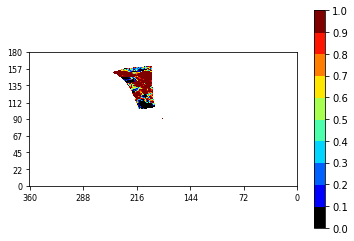

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import calendar
import pprint
data = cf

data_shape = data.shape

cmap = [(0.0,0.0,0.0)] + [(cm.jet(i)) for i in range(1,256)] 
cmap = mpl.colors.ListedColormap(cmap)

bounds = [0.0, 0.1, 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

img = plt.imshow(np.fliplr(data), cmap=cmap, norm=norm,
                  interpolation='none', origin='lower')

cbar_bounds = [0.0, 0.1, 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cbar_ticks = [0.0, 0.1, 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]             
               
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticks, fontsize=10)

l = [int(i) for i in np.linspace(0,data_shape[1],6)]
plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=8 )

l = [int(i) for i in np.linspace(0,data_shape[0],9)]
plt.yticks(l, l, rotation=0, fontsize=8 )

title = 'Cloud Fraction \n MYD06 C6 ({}-{:02d}-{:02d}; {:02d}h{:02d})'
#plt.title(title.format( year, month, day, hh, mm), fontsize=10)
plt.show()